# Blochnium qubit and phase slip model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings
import ipywidgets as widgets
%matplotlib inline
%pwd
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

## Fluxonium Hamiltonian

In [2]:
#First, simulate the circuit using fluxonium model
N = 50 #number of levels
E_J = 4 #Josephson energy, GHz
E_C = 10 #Charging energy, GHz
E_L = 0.05 #Inductive energy, GHz
level_num = 10
phi_ext = np.linspace(0,1,101)
energies = np.zeros((len(phi_ext), level_num))
states = np.zeros((len(phi_ext), level_num, N))
max_display_y = 10

In [3]:
for idx, phi in enumerate(phi_ext):
    H = fluxonium.bare_hamiltonian(N, E_L, E_C, E_J, phi*2*np.pi)
    energies[idx, :] = H.eigenenergies()[:level_num]

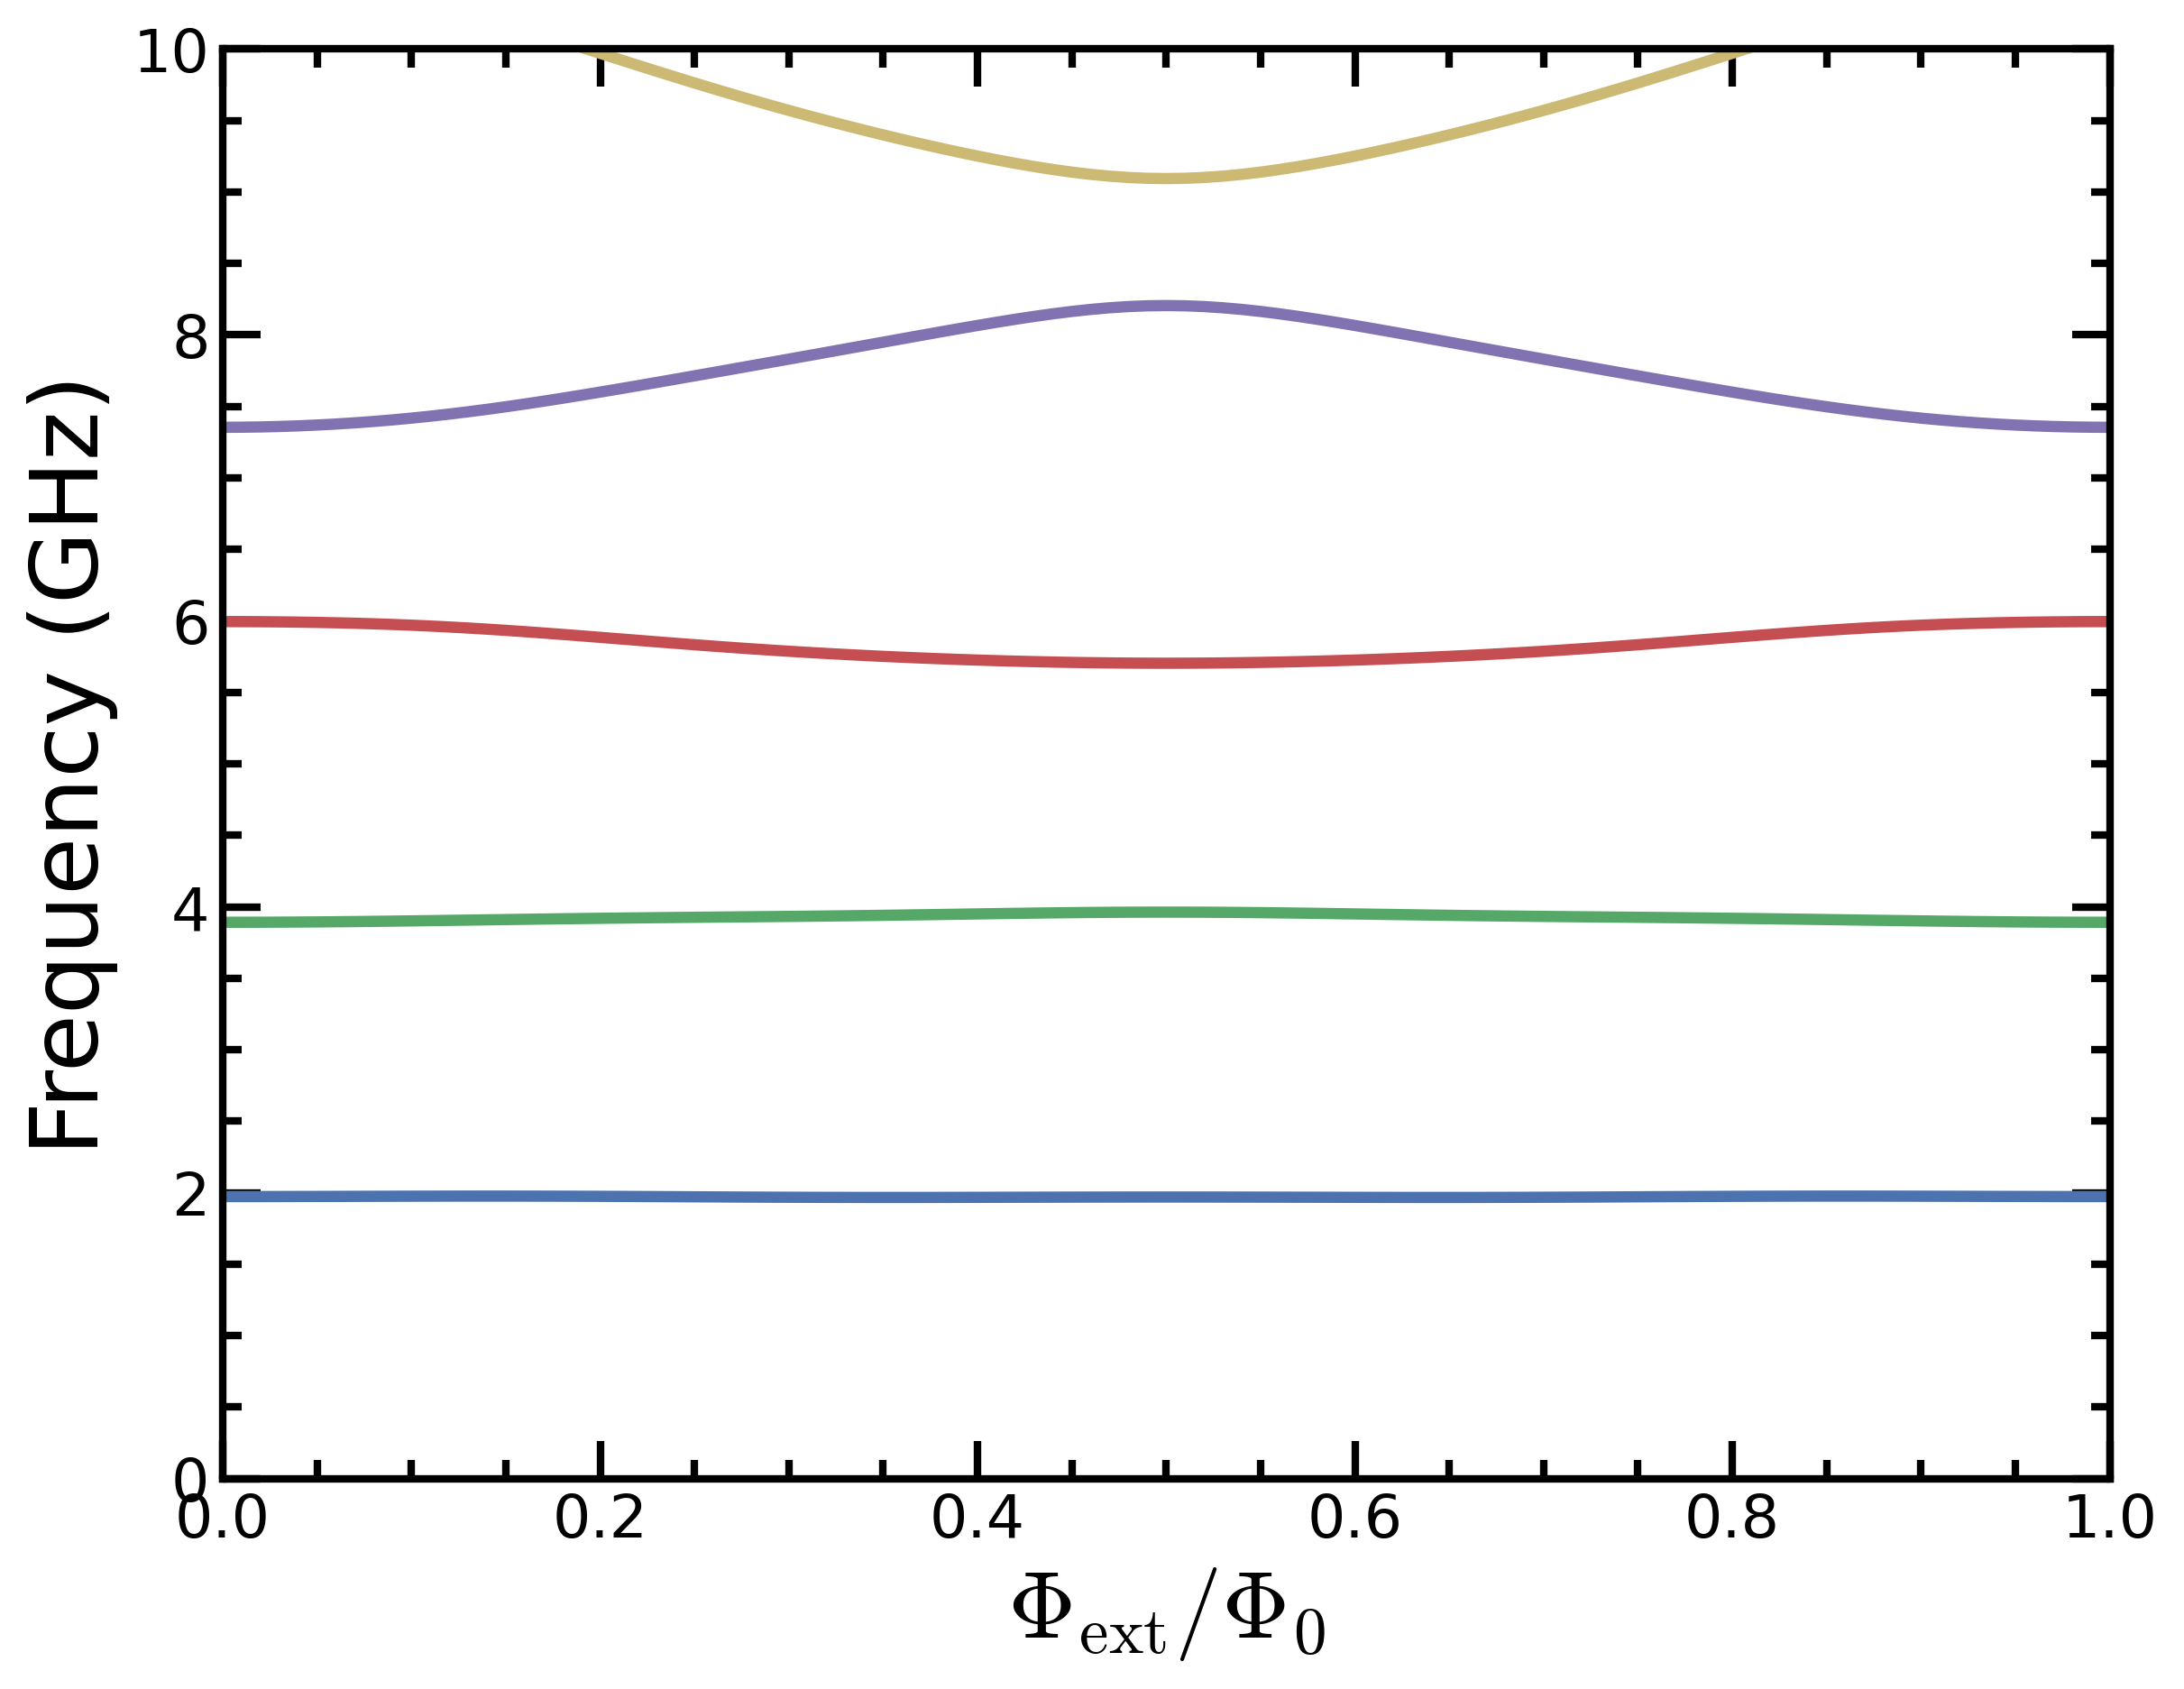

In [4]:
plt.figure(figsize=[9,7])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([0,max_display_y])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(1,level_num):
    plt.plot(phi_ext, energies[:,idx]-energies[:,0], linewidth = 3.0)

## Phase slip Hamiltonian
$$
H_{PS} = E_L \phi^2/2 + E_B\cos(2\pi n)
$$

In [10]:
def hamiltonian_ps(N, E_L, E_B1, E_B2, E_B3, phi_ext):
    """
    Return the phase slip hamiltonian as a Qobj instance.
    """
    h = np.diag(0.5 * E_L *(2*np.pi)**2*(np.arange(-N,N+1)-phi_ext)**2) \
    + 0.5*E_B1 * (np.diag(np.ones(2*N), 1) + np.diag(np.ones(2*N), -1)) \
    + 0.5*E_B2 * (np.diag(np.ones(2*N-1), 2) + np.diag(np.ones(2*N-1), -2))\
    + 0.5*E_B3 * (np.diag(np.ones(2*N-2), 3) + np.diag(np.ones(2*N-2), -3))
    return Qobj(h)

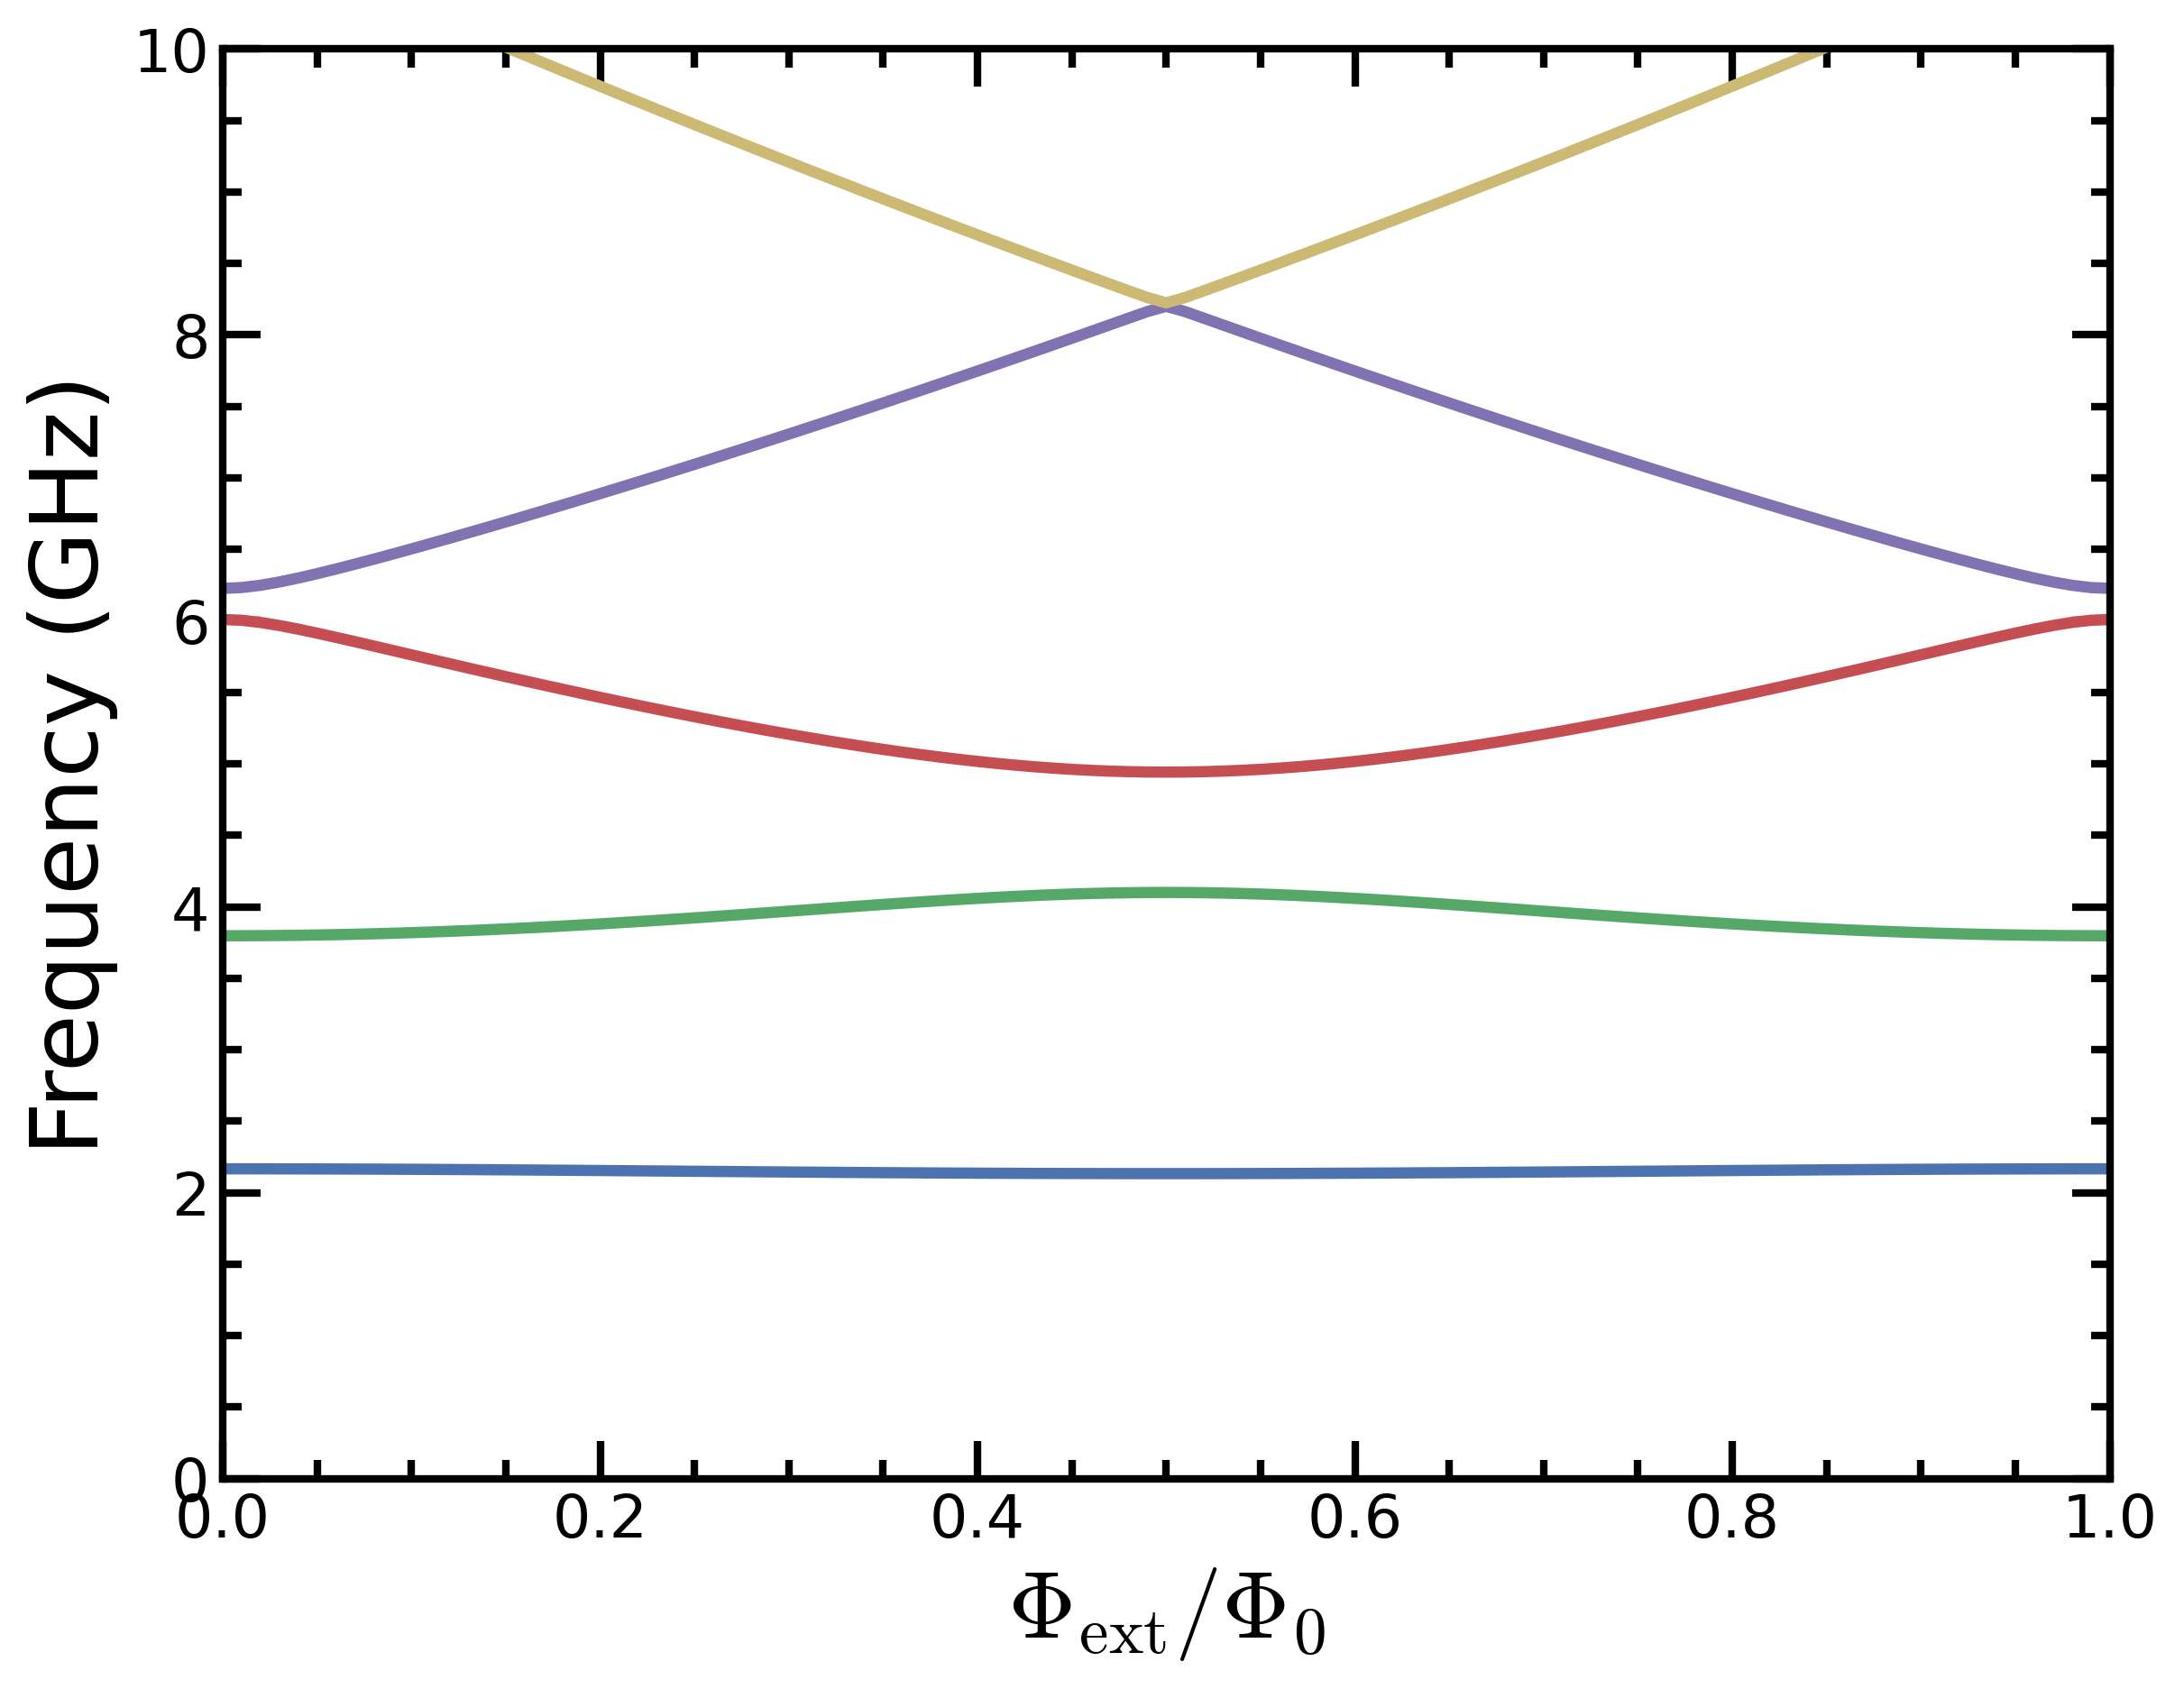

In [11]:
energies_ps = np.zeros((len(phi_ext), level_num))
E_B1 = 3
E_B2 = 0
E_B3 = 0
for idx, phi in enumerate(phi_ext):
    H_ps = hamiltonian_ps(N, E_L, E_B1, E_B2, E_B3, phi)
    energies_ps[idx, :] = H_ps.eigenenergies()[:level_num]
    
plt.figure(figsize=[9,7])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([0,max_display_y])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(1,level_num):
    plt.plot(phi_ext, energies_ps[:,idx]-energies_ps[:,0], linewidth = 3.0)

In [12]:
y_data = np.concatenate([energies[:,1]-energies[:,0], energies[:,2]-energies[:,0], energies[:,3]-energies[:,0]], axis = 0)
x_data = np.concatenate([phi_ext, phi_ext, phi_ext], axis = 0)

def fit_func(x_data, E_B1, E_B2, E_B3):
    #Fit the 0-2 transition
    trans_freq1 = np.zeros_like(phi_ext)
    trans_freq2 = np.zeros_like(phi_ext)
    trans_freq3 = np.zeros_like(phi_ext)
    for idx in range(len(phi_ext)):
        H = hamiltonian_ps(N, E_L, E_B1, E_B2, E_B3, phi_ext[idx])
        trans_freq1[idx] = H.eigenenergies()[1] - H.eigenenergies()[0]
        trans_freq2[idx] = H.eigenenergies()[2] - H.eigenenergies()[0]
        trans_freq3[idx] = H.eigenenergies()[3] - H.eigenenergies()[0]
        
    return np.concatenate([trans_freq1, trans_freq2, trans_freq3], axis=0)

from scipy.optimize import curve_fit

opt, cov = curve_fit (fit_func, xdata = x_data, ydata = y_data)
E_B1_fit, E_B2_fit, E_B3_fit = opt
print (opt)

[3.81712281 0.86632178 0.30111761]


<Figure size 2700x1800 with 0 Axes>

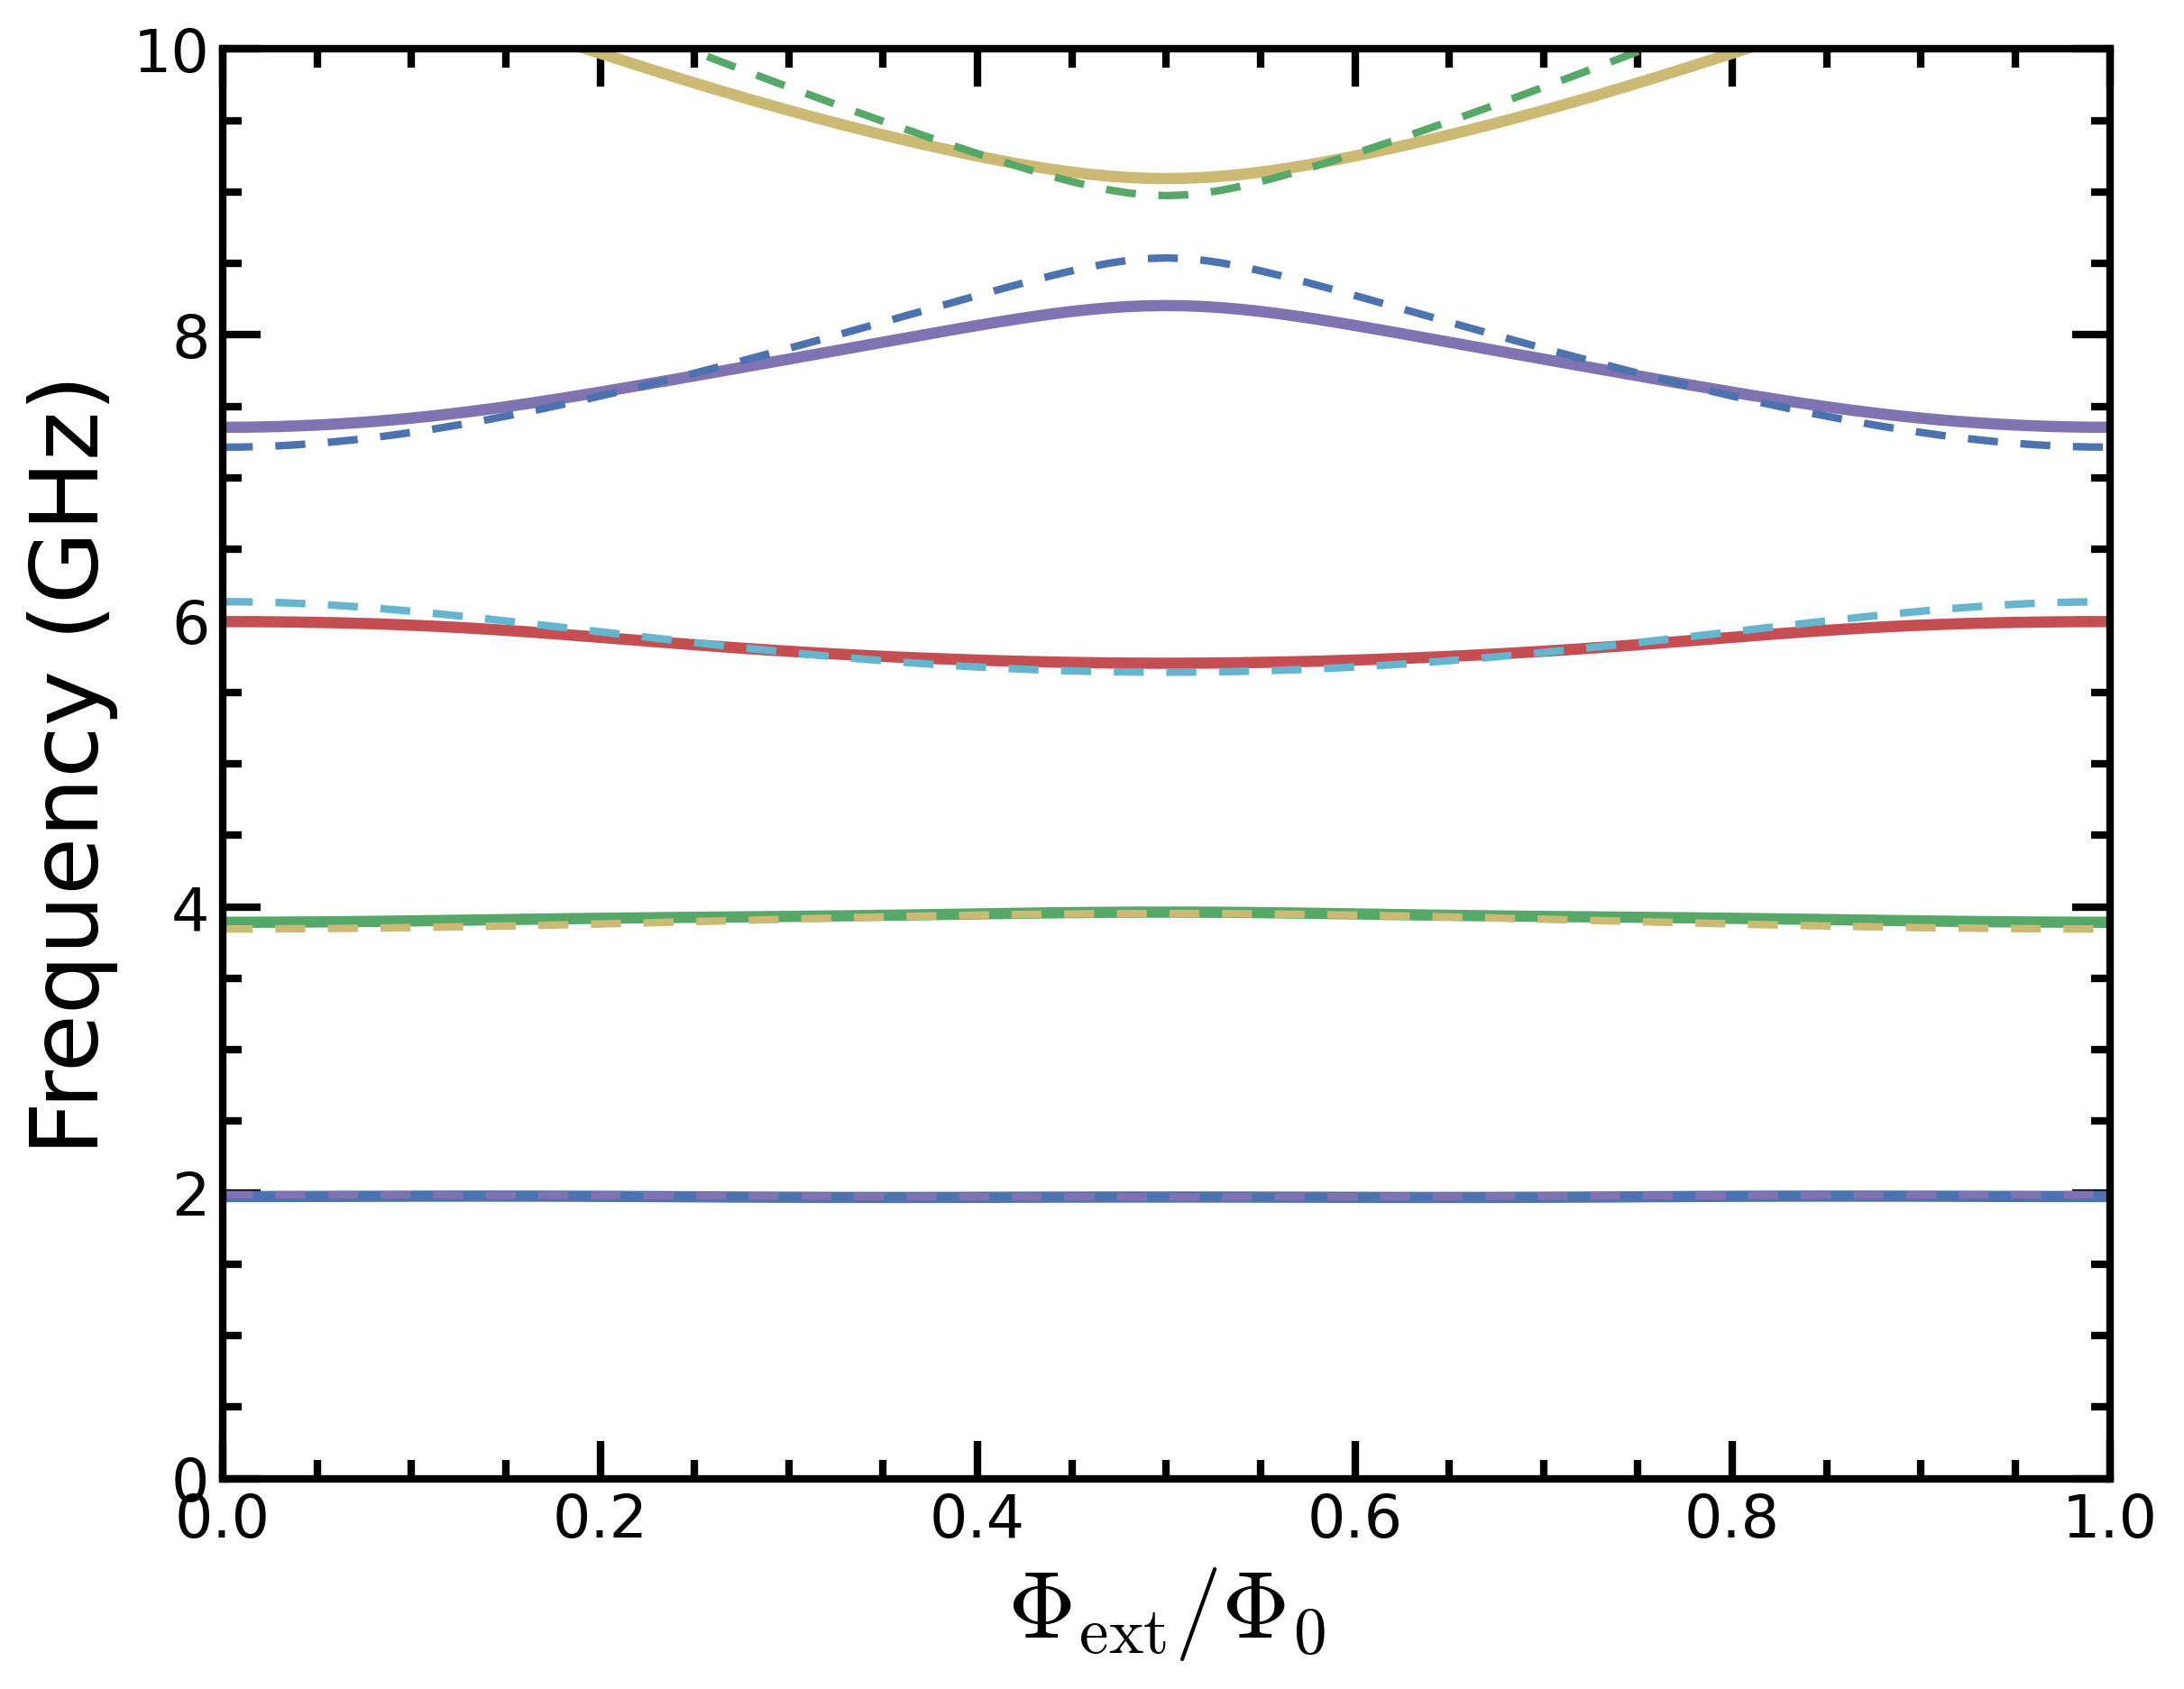

In [13]:
plt.figure(figsize = [9,6])
for idx, phi in enumerate(phi_ext):
    H_ps = hamiltonian_ps(N, E_L, E_B1_fit, E_B2_fit, E_B3_fit, phi)
    energies_ps[idx, :] = H_ps.eigenenergies()[:level_num]

plt.figure(figsize=[9,7])
plt.xlim([phi_ext[0], phi_ext[-1]])
plt.ylim([0,max_display_y])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')
for idx in range(1,level_num):
    plt.plot(phi_ext, energies[:,idx]-energies[:,0], linewidth = 3.0)
for idx in range(1,level_num):
    plt.plot(phi_ext, energies_ps[:,idx]-energies_ps[:,0], linestyle = '--', linewidth = 2.0)

In [9]:
slip_rate = 4/np.sqrt(np.pi) * (E_J**3*E_C)**(0.25) * np.exp(-8*np.sqrt(E_J/E_C))
print (slip_rate)

0.07205339814191838
